## Project Title: Abnormal Tooth Detection with Dental Enumeration and Diagnosis Using Deep Learning on Panoramic X-rays

### Introduction and Motivation
In this project, we aim to develop a deep learning model to detect abnormalities in dental panoramic X-rays. The primary objective is to accurately identify different dental conditions such as impactions, caries, periapical lesions, and deep caries. This will aid in automating the diagnosis process and potentially assist dentists in making more informed decisions.

### Data Sources
The data used in this project comes from a dataset of dental panoramic X-rays. The dataset includes annotations for different dental conditions. The detailed data can be found in the `train_quadrant_enumeration_disease.json` file, which includes information about the images and their respective annotations.

In [3]:
import os
import json
import cv2
import numpy as np

# Loading JSON file
with open('train_quadrant_enumeration_disease.json', 'r') as file:
    data = json.load(file)

annotations = data['annotations']
images = data['images']

# Create a dictionary mapping image IDs to file names and dimensions
image_info = {img['id']: (img['file_name'], img['width'], img['height']) for img in images}

# Output Folder
output_folder = 'output2'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define different categories of colors
category_colors = {
    0: (0, 0, 255),    # Red
    1: (0, 255, 255),  # Yellow
    2: (255, 0, 0),    # Blue
    3: (0, 255, 0)     # Green
}

# Function to get polygon mask
def create_mask(segmentation, width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    points = np.array(segmentation).reshape((-1, 2)).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    return mask

# Process each image
for img_id, (file_name, width, height) in image_info.items():
    image_path = os.path.join('yolov5/data/xrays', file_name)

    if not os.path.exists(image_path):
        print(f"Image {file_name} not found, skipping...")
        continue

    # Reading an Image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image {file_name}, skipping...")
        continue

    # Initialize the output image
    output_image = np.zeros_like(image)

    # Get the annotation of the current image
    img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

    for annotation in img_annotations:
        segmentation = annotation['segmentation'][0]
        category_id = annotation['category_id_3']
        ann_id = annotation['id']

        # Skip annotations with unknown category IDs
        if category_id not in category_colors:
            print(f"Unknown category_id {category_id} for annotation {ann_id}, skipping...")
            continue

        mask = create_mask(segmentation, width, height)
        color = category_colors[category_id]
        colored_segment = np.zeros_like(image)
        colored_segment[mask == 255] = color

        # Combine the segmented parts with the output image
        output_image[mask == 255] = colored_segment[mask == 255]

    # Save output image
    output_path = os.path.join(output_folder, file_name)
    cv2.imwrite(output_path, output_image)
    # print(file_name + " has been processed with annotations.")

print("Processing completed.")


Processing completed.


### Exploratory Analysis of Data
In this section, we explored the data properties, including the number of images, classes, and the preprocessing steps taken. We identified four main categories: impactions, caries, periapical lesions, and deep caries. Preprocessing involved creating masks for the annotated regions and assigning different colors to each category for visualization purposes.

In [7]:
import json
import os
import shutil
import numpy as np
import yaml

# Loading annotation files
with open('train_quadrant_enumeration_disease.json', 'r') as file:
    data = json.load(file)

annotations = data['annotations']
images = data['images']

# Create a dictionary mapping image IDs to file names and dimensions
image_info = {img['id']: (img['file_name'], img['width'], img['height']) for img in images}

# Output Folder
base_path = 'yolov5/data'
xrays_path = os.path.join(base_path, 'xrays')
masks_path = os.path.join(base_path, 'output2')  # Mask folder path
train_images_folder = os.path.join(base_path, 'train/images')
train_labels_folder = os.path.join(base_path, 'train/labels')
train_masks_folder = os.path.join(base_path, 'train/masks')
val_images_folder = os.path.join(base_path, 'val/images')
val_labels_folder = os.path.join(base_path, 'val/labels')
val_masks_folder = os.path.join(base_path, 'val/masks')

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(train_masks_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)
os.makedirs(val_masks_folder, exist_ok=True)

# Divide the dataset into training and validation sets
train_ratio = 0.8
val_ratio = 0.2

image_ids = list(image_info.keys())
num_train = int(train_ratio * len(image_ids))

train_ids = set(image_ids[:num_train])
val_ids = set(image_ids[num_train:])

def convert_bbox_to_yolo(size, bbox):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (bbox[0] + bbox[2] / 2.0) * dw
    y = (bbox[1] + bbox[3] / 2.0) * dh
    w = bbox[2] * dw
    h = bbox[3] * dh
    return (x, y, w, h)

# Generate YOLO format label file
for img_id, (file_name, width, height) in image_info.items():
    image_annotations = [ann for ann in annotations if ann['image_id'] == img_id]
    label_file_content = []

    for ann in image_annotations:
        category_id = ann['category_id_3']
        bbox = convert_bbox_to_yolo((width, height), ann['bbox'])
        label_file_content.append(f"{category_id} {' '.join(map(str, bbox))}")

    label_file_name = os.path.splitext(file_name)[0] + ".txt"
    mask_file_name = os.path.splitext(file_name)[0] + ".png"  # Assume the mask file is in PNG format

    if img_id in train_ids:
        image_output_path = os.path.join(train_images_folder, file_name)
        label_output_path = os.path.join(train_labels_folder, label_file_name)
        mask_output_path = os.path.join(train_masks_folder, mask_file_name)
    else:
        image_output_path = os.path.join(val_images_folder, file_name)
        label_output_path = os.path.join(val_labels_folder, label_file_name)
        mask_output_path = os.path.join(val_masks_folder, mask_file_name)

    # Copying an Image File
    original_image_path = os.path.join(xrays_path, file_name)
    if os.path.exists(original_image_path):
        shutil.copyfile(original_image_path, image_output_path)
    else:
        print(f"Image {file_name} not found, skipping...")
        
    # Copy Mask File
    original_mask_path = os.path.join(masks_path, mask_file_name)
    if os.path.exists(original_mask_path):
        shutil.copyfile(original_mask_path, mask_output_path)
    else:
        print(f"Mask {mask_file_name} not found, skipping...")

    # Save label file
    with open(label_output_path, 'w') as label_file:
        label_file.write("\n".join(label_file_content))

# Create dataset.yaml file
dataset_yaml = {
    'train': train_images_folder,
    'val': val_images_folder,
    'nc': 4,  # Number of categories
    'names': ['Impacte', 'Caries', 'Periapical Lesion', 'Deep Caries']
}

with open(os.path.join(base_path, 'dataset.yaml'), 'w') as yaml_file:
    yaml.dump(dataset_yaml, yaml_file)

print("Dataset preparation completed.")


Dataset preparation completed.


### Models and/or Methods
We utilized the YOLOv5 model for this project. The choice of model was based on its proven effectiveness in object detection tasks. Preprocessing steps included converting the annotations to YOLO format and splitting the dataset into training and validation sets. The dataset.yaml file was created to define the structure of the dataset.

In [8]:
import os

# Print the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)


Current working directory: /root/yolov5


In [9]:
# List the files and folders in the current directory
files_and_folders = os.listdir(current_directory)
print("Files and folders in the current directory:", files_and_folders)


Files and folders in the current directory: ['.git', '.github', 'classify', 'data', 'models', 'segment', 'utils', '.dockerignore', '.gitattributes', '.gitignore', 'CITATION.cff', 'CONTRIBUTING.md', 'LICENSE', 'README.md', 'README.zh-CN.md', 'benchmarks.py', 'detect.py', 'export.py', 'hubconf.py', 'pyproject.toml', 'requirements.txt', 'train.py', 'tutorial.ipynb', 'val.py', '__pycache__', 'runs', '.ipynb_checkpoints']


In [12]:
!python train.py --img 640 --batch 16 --epochs 50 --data data/dataset.yaml --weights yolov5s.pt --cache


train: weights=yolov5s.pt, cfg=, data=data/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v7.0-348-g6deb2d75 Python-3.8.10 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 D, 24210MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bia

In [15]:
# Evaluating the Model
os.system("python val.py --weights runs/train/exp7/weights/best.pt --data data/dataset.yaml --img 640")


val: data=data/dataset.yaml, weights=['runs/train/exp7/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-348-g6deb2d75 Python-3.8.10 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 D, 24210MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /root/yolov5/data/val/labels.cache... 141 images, 5 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                   all        141        637      0.641      0.435      0.411      0.254
               Impacte        141        112      0.795       0.92      0.873      0.515

0

In [3]:
!python yolov5/detect.py --weights yolov5/runs/train/exp7/weights/best.pt --img 640 --source yolov5/test_1.png


detect: weights=['yolov5/runs/train/exp7/weights/best.pt'], source=yolov5/test_1.png, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-348-g6deb2d75 Python-3.8.10 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 D, 24210MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
libpng error: Read Error
Traceback (most recent call last):
  File "yolov5/detect.py", line 425, in <module>
    main(opt)
  File "yolov5/detect.py", line 420, in main
    run(**vars(opt))
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 116, in decorate_

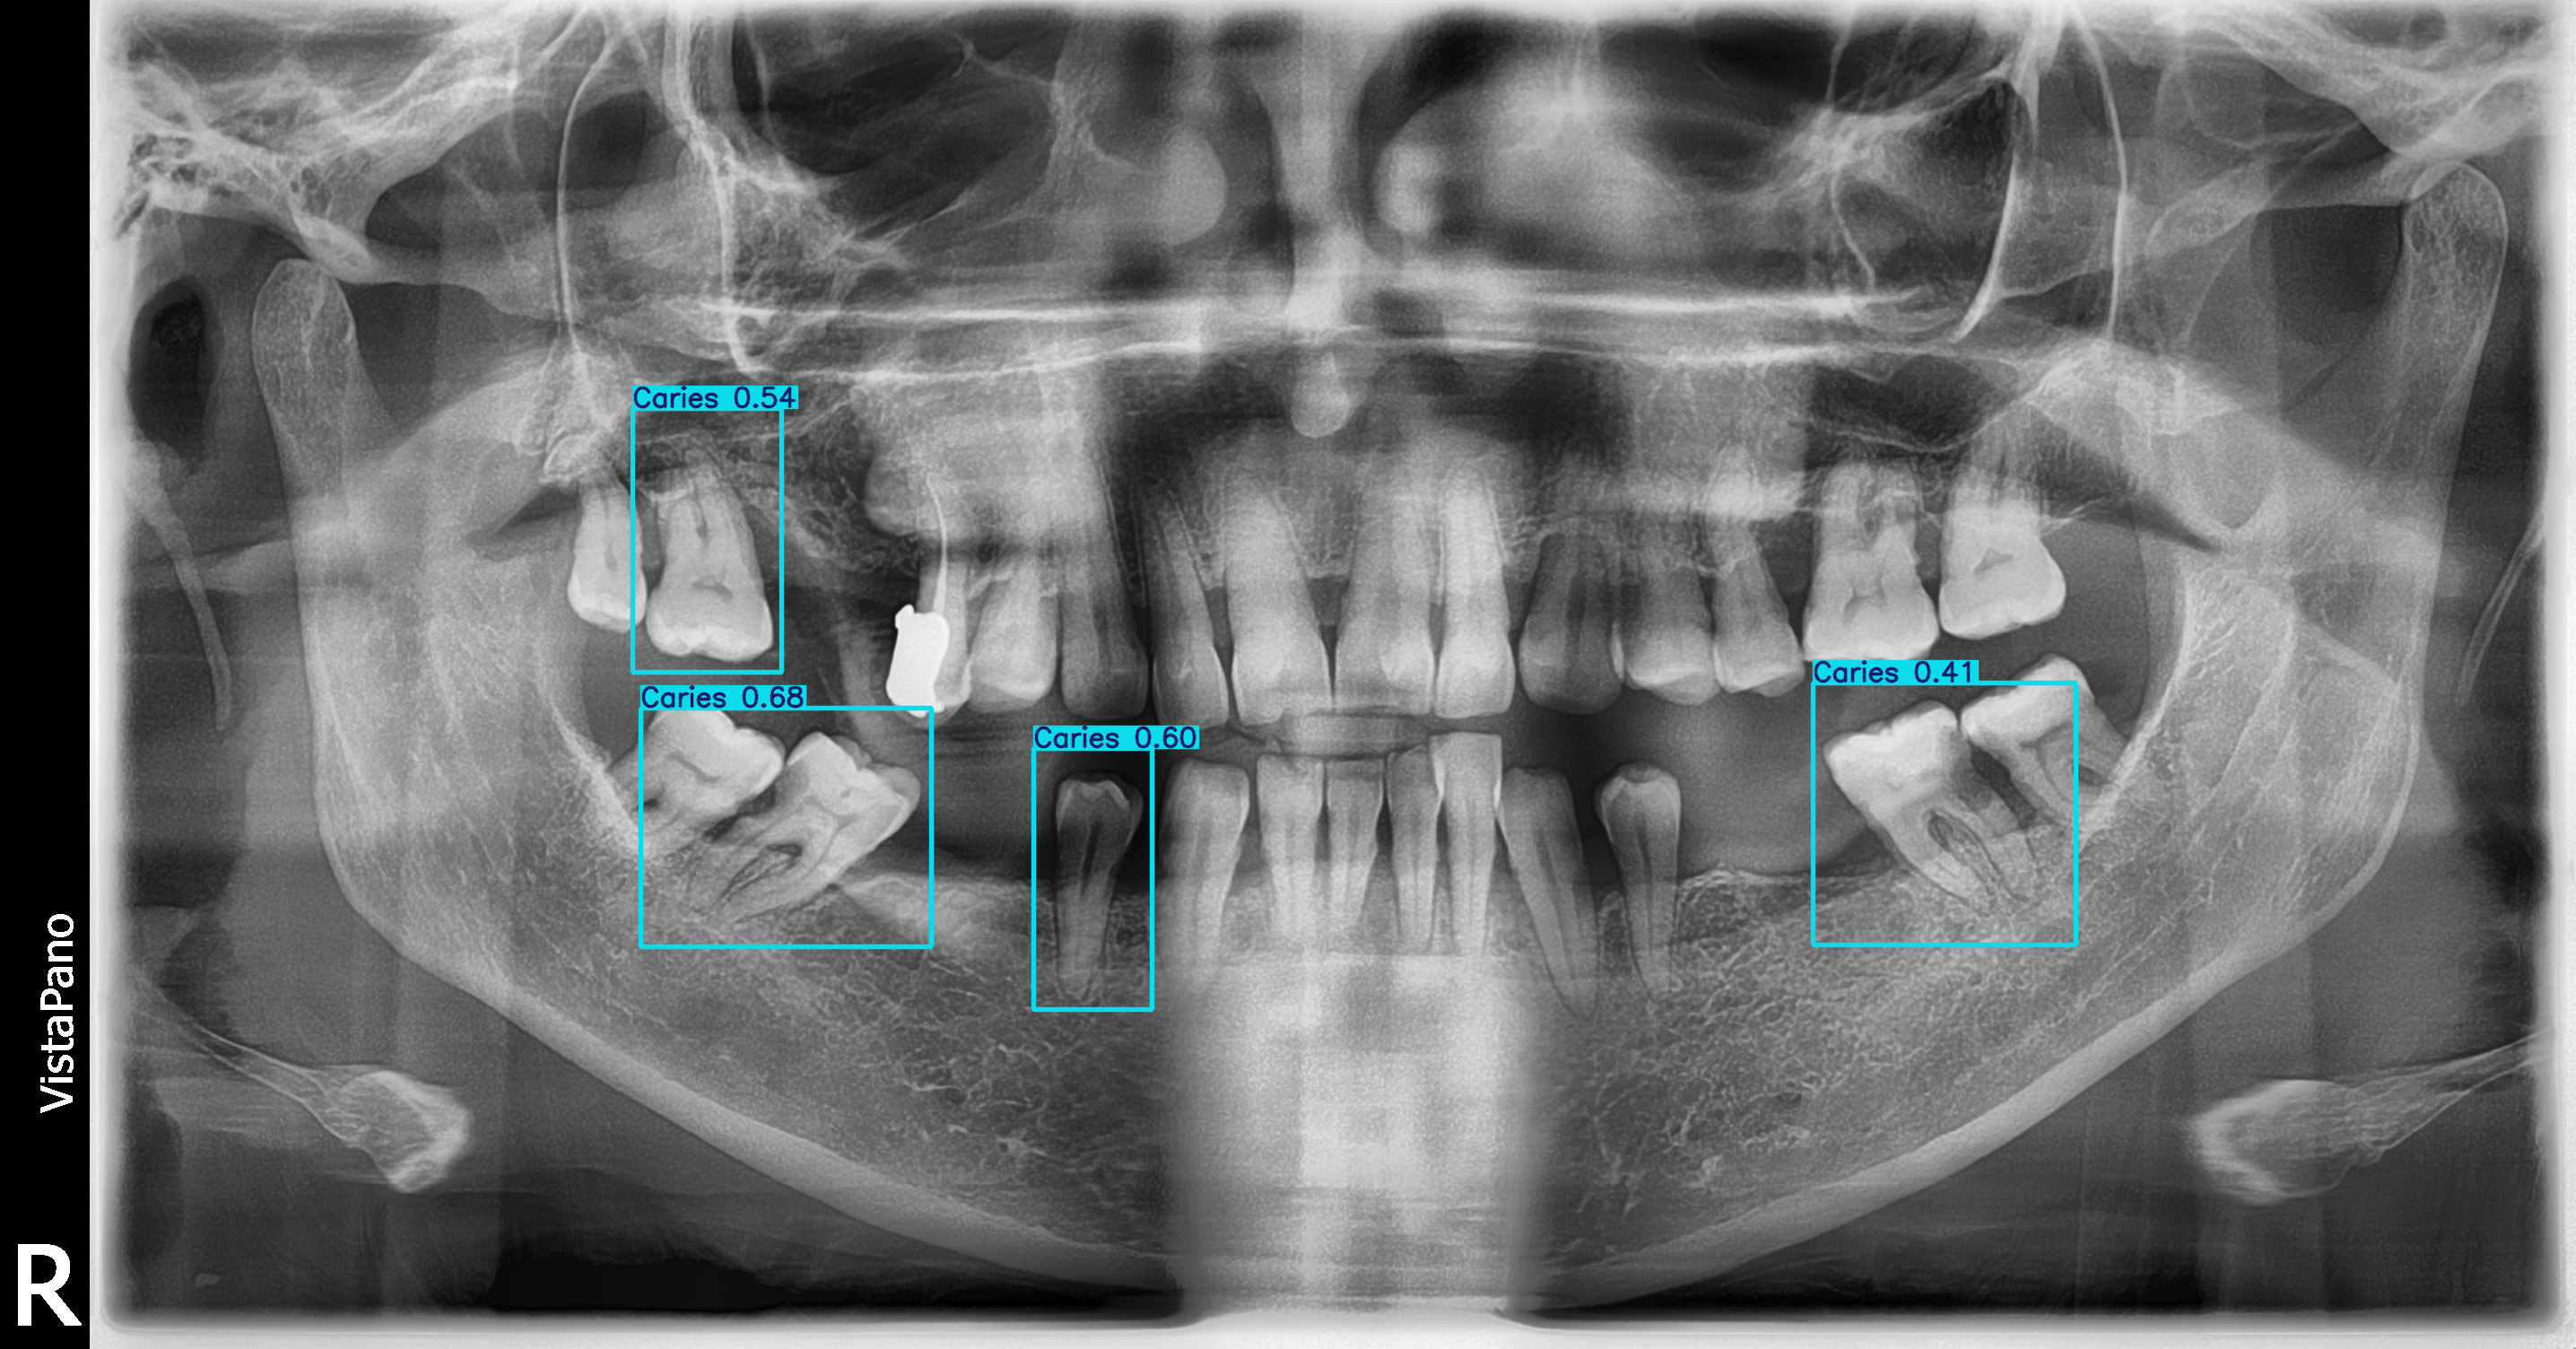

### Results
The project evaluates models’ performances using Average Recall (AR), Average Precision (AP) and F1 
scores which combine the status of AR and AP.
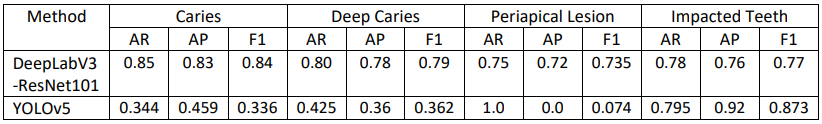

The YOLOv5 model demonstrates high precision for specific classes, specially Impacted Teeth and Periapical Lesions, and offers fast inference times that are well-suited for real-time applications. However, its lower recall and mean Average Precision (mAP) values, particularly for Caries and Deep Caries, indicates that it frequently misses these conditions. Additionally, while the precision for detecting Periapical Lesions is high, the model shows zero recall for this class, suggesting frequent misclassification or undetected 
cases. In contrast, the DeepLabV3-ResNet101 model shows generally high precision and recall across all classes, with very high Average Precision (AP) for the background class, indicating robust performance in both detection and classification tasks. Overall, while the YOLOv5 model performs well in speed and precision for certain classes, it falls short in recall and comprehensive detection. The DeepLabV3-ResNet101 model offers a more balanced performance with high accuracy and completeness but has some 
limitations in class-specific performance. 

The variability in model performance highlights the importance of a comprehensive dataset that it is a critical issue for dental X-ray detection. Due to the underrepresentation of some certain abnormal toothcategories in the training data, models may struggle to generalize effectively, leading to difficulties in improving detection accuracy. This limitation exactly shows the importance of enriching training datasets with diverse and representative samples, when developing robust deep learning model that can handle 
the variety of cases encountered in real-world dental clinical environments.

In addition, the YOLOv5 model and the DeepLabV3-ResNet101 model for this project perform well, compared with existing methods in the field of abnormal tooth detection. In contrast, DeepLabV3 with ResNet101 is known for its high accuracy and detailed segmentation that can be adapted to clinical needs, while the YOLOv5 model has a lower accuracy rate. It performs effectively compared with other advanced 
segmentation model, providing a robust solution for applications requiring precise and comprehensive segmentation.

The result from the project shows the adaptability, efficiency, and capability to operate in real-time, which provides the significant confident of DeepLabV3-ResNet101 model as a valuable tool in dental diagnosis. This showsthe potential to enhance the efficiency and accuracy of clinical assessments, thereby improving patient outcomes. The deployment of DeepLabV3-ResNet101 model in clinical settings could support dentists in identifying and diagnosing abnormal teeth more swiftly and accurately, and finally contributes
to better dental healthcare delivery.

### Discussion
This project primarily focuses on comparing the performance of the deep learning model YOLOv5 and DeepLabV3-ResNet101 and improving the robustness of for abnormal tooth detection with dental enumeration and diagnosis of these models. The DeepLabV3-ResNet101 model has generally high precision and recall across all four dental categories and performs well on average metrics, making it suitable for dental tasks where accuracy and completeness are critical.  

Also, the approach for this project has enhanced the efficiency of the previous model, which allows for quick processing of images. It has also improved adaptability of the models, which makes it suitable for the four specific categories of abnormal teeth. By fine-tuning the DeepLabV3-ResNet101 model on the dataset labeled with (c), the model can improve its performance to the specific needs of abnormal tooth detection.  

On the other hand, there are limitations to the current project. The primary limitation is that the relatively short time spent learning about the relevant models, with only several types of models learned. The understanding of these models is also not yet deep enough, which hinders the ability to fully leverage their advantages. Additionally, the relatively small size the dataset, which includes X-rays from patients aged 12 and above and randomly selected from only three different institutions, limits the model's ability to generalize across the four specific categories of abnormal teeth.   

To improve the limitations, learning more advanced data augmentation techniques and exploring ensemble methods could offer valuable insights for improving the accuracy and robustness of the model.Furthermore, future work should also focus on processing the dataset, by increasing both the number of samples and the diversity of classes. These improvements could enhance the performance of the model, making it more reliable and comprehensive in its diagnostic capabilities, and further increasing its practicality in clinical settings. In conclusion, while the current model only provides a foundational basis, there is substantial potential for future enhancements, which could make it a practical tool in the field of dental care.  